In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pickle
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from sympy.physics.wigner import wigner_3j, wigner_6j

sys.path.append('./molecular-state-classes-and-functions/')
from classes import UncoupledBasisState, CoupledBasisState, State

In [3]:
from functions import find_state_idx_from_state, make_transform_matrix
from functions import make_hamiltonian, make_hamiltonian_B, make_QN, ni_range, vector_to_state, matrix_to_states
from state_functions import find_exact_states, calculate_BR
from hamiltonian_functions import reduced_basis_hamiltonian
from laser_functions import optical_coupling_matrix, ED_ME_mixed_state, calculate_power_needed, laser_field
from collapse_functions import collapse_matrices
from density_functions import generate_density_matrix

## X State Hamiltonian

In [4]:
H_X_uc = make_hamiltonian("./stored_data/TlF_X_state_hamiltonian_J0to4.pickle")

In [5]:
Jmin = 0
Jmax = 4
I_F = 1/2
I_Tl = 1/2
QN_X = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
     ]

In [6]:
### Transform Hamiltonian to coupled basis ###
#Load transform matrix
with open("./stored_data/UC_to_C_j0to4.pickle","rb") as f:
    S_trans = pickle.load(f)

In [7]:
#Transform matrix
E = np.array((0,0,0))
B = np.array((0,0,0.001))
H_X =  S_trans.conj().T @ H_X_uc(E, B) @ S_trans

In [8]:
D, V = np.linalg.eigh(H_X)

#Diagonalize the Hamiltonian
H_X_diag = V.conj().T @ H_X @ V

#Remove very small entries from V
# V[np.abs(V) < 1e-5] = 0

#New set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

state = vector_to_state(V[:,1],QN_X)
state.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>


In [9]:
#Define what states are to be included in the simulation
Js_g = [0,1,2,3]
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag)

In [10]:
H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

#Set small off diagonal terms to zero
H_X_red[np.abs(H_X_red) < 0.1] = 0

## B State Hamiltonian

In [11]:
H_B = make_hamiltonian_B("./stored_data/B_hamiltonians_symbolic_coupled_P_1to3.pickle")

In [12]:
Jmin = 1
Jmax = 3
I_F = 1/2
I_Tl = 1/2
Ps = [-1, 1]
QN_B = [CoupledBasisState(F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B')
      for J  in ni_range(Jmin, Jmax+1)
      for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
      for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
      for mF in ni_range(-F, F+1)
      for P in Ps
     ]

In [13]:
D,V = np.linalg.eigh(H_B)

#Diagonalize the Hamiltonian
H_B_diag = V.conj().T @ H_B @ V

#New set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

state = vector_to_state(V[:,1],QN_B)
state.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [14]:
#Define what states are to be included in the simulation
J = 1
F1 = 3/2
F = 1
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for mF in ni_range(-F, F+1)
                 ]

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag)

In [15]:
H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Optical Couplings
Generating the matrix of optical couplings here. Assuming rotating frame so no $\exp(i\omega t)$ time-dependence

In [16]:
#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

ground_states_laser = find_exact_states(ground_states_laser_approx, H_X_diag, QN_X_diag)

#Excited states for laser
excited_states_laser = excited_states

In [17]:
%%time
#Coupling laser for z-polarized
H_laser_z = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([0,0,1]), 
                                             reduced = False)
H_laser_z[np.abs(H_laser_z) < 1e-3*np.max(np.abs(H_laser_z))] = 0

#Check that coupling matrix is hermitian
print(np.allclose(H_laser_z, H_laser_z.conj().T))

#Check number of couplings added
print(H_laser_z[np.abs(H_laser_z)>0].shape)

True
(16,)
Wall time: 40.8 s


In [18]:
%%time
H_laser_x = optical_coupling_matrix(QN, ground_states_laser, excited_states_laser, pol_vec = np.array([1,0,0]), 
                                             reduced = False)
H_laser_x[np.abs(H_laser_x) < 1e-3*np.max(np.abs(H_laser_x))] = 0

#Check that coupling matrix is hermitian
print(np.allclose(H_laser_x, H_laser_x.conj().T))

#Check number of couplings added
print(H_laser_x[np.abs(H_laser_x)>0].shape)

True
(32,)
Wall time: 42.3 s


In [19]:
#Calculate the matrix element for the "main" transition so that coupling matrix can be scaled to have appropriate rabi rate

#Define approximate form of main ground state
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_main_i = find_state_idx_from_state(H_X_diag,ground_main_approx, QN_X_diag)
ground_main = QN_X_diag[ground_main_i]

#Define approximate form of main excited state
excited_main_approx = 1*CoupledBasisState(J = 1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_main_i = find_state_idx_from_state(H_B_diag,excited_main_approx, QN_B_diag)
excited_main = QN_B_diag[excited_main_i]

ME_main = ED_ME_mixed_state(excited_main, ground_main, pol_vec = np.array([0,0,1]))

(-0.39444661382277774+0j)


In [1084]:
def square_wave(t, frequency, phase = 0):
    return 0.5*(1+signal.square(2*np.pi*frequency*t+phase))

In [1218]:
#Calculate effective dipole moment for the optical transitions
Gamma = 1/100e-9 #Natural linewidth in 2*pi*Hz
f = 3e8/271.7e-9 #Frequency in Hz
D_eff = (np.sqrt(3*np.pi*8.85e-12*1.05e-34*3e8**3*Gamma/(2*np.pi*f)**3)
         /(1/3e8 * 1e-21)* 0.393430307 * 5.291772e-9/4.135667e-15)  #Hz/(V/cm)

#Generate optical coupling matrix with set rabi rate
Omega = 2*np.pi*1000e3 #[2pi*Hz]
Omega = 1*Gamma

#Calculate the electric field required to give the desired Rabi rate
r_t = lambda t: np.array([0,0,0])
laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

#Define frequency for polarization switching
omega_p = 1*Gamma
wp = omega_p/(2*np.pi)
H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
# H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

H_oc = Omega*H_laser_z/ME_main

In [1219]:
Omega/Gamma

1.0

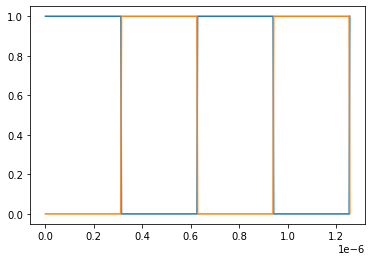

In [1220]:
_t = np.linspace(0,2/wp, 501)
plt.plot(_t, square_wave(_t, wp, 0))
plt.plot(_t, square_wave(_t, wp, np.pi))

## Total Hamiltonian

In [1221]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

In [1222]:
_H = np.zeros([67,67], dtype = 'complex')
_H[:64, :64] = H_X_shifted
# _H[:64, :64] = 0
_H[64:,64:] = H_B_shifted
# _H[64:,64:] = 0

def Hamiltonian(t):
    return _H + H_oc_t(t)

In [1223]:
Hamiltonian(0).shape

(67, 67)

In [1224]:
excited_test_approx = 1*CoupledBasisState(J = 1, F1=3/2, F=1, mF=0, I1=1/2, I2=1/2, electronic_state='B', P = -1, Omega = 1)
excited_test_i = find_state_idx_from_state(H_B_diag,excited_test_approx, QN_B_diag)
excited_test = QN_B_diag[excited_test_i]

ground_test_approx = 1*CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = 1, Omega = 0)
ground_test_i = find_state_idx_from_state(H_X_diag,ground_test_approx, QN_X_diag)
ground_test = QN_X_diag[ground_test_i]

BRs = calculate_BR(excited_test, ground_states)

In [1225]:
C_array = collapse_matrices(QN, ground_states, excited_states, gamma = Gamma)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

## Density Matrix

In [1226]:
# Define states that are populated initially
Js = [0,1,2,3]
states_pop_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
              for J  in Js
              for F1 in ni_range(np.abs(J-I_Tl),J+I_Tl+1)
              for F in ni_range(np.abs(F1-I_F),F1+I_F+1)
              for mF in ni_range(-F, F+1)
             ]

states_pop = []
for state in states_pop_approx:
    i = find_state_idx_from_state(H_X_diag,state, QN_X_diag)
    states_pop.append(QN_X_diag[i])
    
pops = np.ones(len(states_pop))/len(states_pop)

rho_ini = generate_density_matrix(QN,states_pop,pops)

In [1227]:
import scipy.constants as cst

def boltzmann_distribution(rot_constant, temperature, J_list):
    init = np.zeros(len(J_list))
    Z = 0
    g = 1
    for J in J_list:
        g = 4*(2*J+1)
        Z += g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))
    for idx, J in enumerate(J_list):
        g = 4*(2*J+1)
        init[idx] = g*np.exp(-rot_constant*J*(J+1)*2*np.pi*cst.hbar/(temperature*cst.k))/Z
    return init

In [1228]:
B_0 = 6.68667*1e9 # Hz
T = 7
boltz_dist = boltzmann_distribution(B_0,T, np.arange(0,150,1))

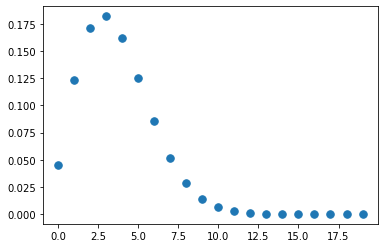

In [1229]:
plt.plot(boltz_dist[:20], '.', ms = 15)

In [1230]:
def get_J_indices(J_list):
    spans = []
    for J in J_list:
        spans.append(4*(2*J+1))
    indices = [(0,spans[0])]
    for idx,span in enumerate(spans[1:]):
        s = np.sum(spans[:idx+1])
        indices.append((s, s+span))
    return indices

In [1231]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2,3])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    print(idx, idx_max-idx_min, boltz_dist[idx]/(idx_max-idx_min))
    np.fill_diagonal(rho_ini[sl], boltz_dist[idx]/(idx_max-idx_min))
rho_ini /= np.diag(rho_ini).sum()

0 4 0.011286978903789161
1 12 0.01029811954327005
2 20 0.008572714492675116
3 28 0.006511169587483691


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


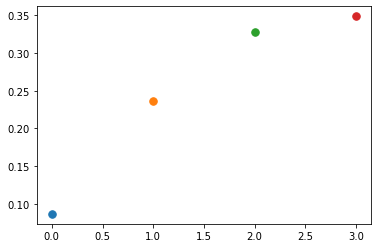

In [1232]:
for idx, (idx_min, idx_max) in enumerate(get_J_indices([0,1,2,3])):
    sl = np.s_[idx_min:idx_max, idx_min:idx_max]
    plt.plot(idx, np.sum(np.diag(rho_ini[sl])), '.', ms = 15)

## ODE Solver

In [1233]:
#Define the rhs of the Lindblad equation
opt = 'greedy'
def Lindblad_rhs(t, rho_vec):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
           -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                   + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()
    
    
    return rhs

In [1234]:
%%time
from scipy.integrate import solve_ivp

#Generate rho vector
rho_vec = rho_ini.flatten()

T = 240e-6

t_span = (0, T)

sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = 1/wp/2, vectorized = True)

Wall time: 1min 35s


In [1235]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

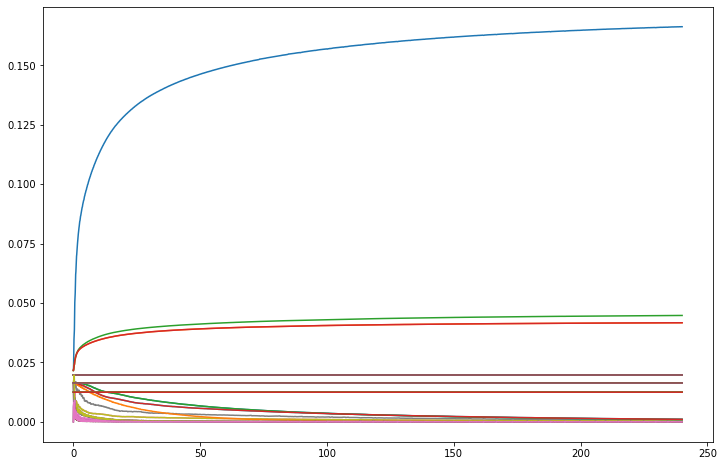

In [1236]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(sol.t*1e6, pop_results.T);

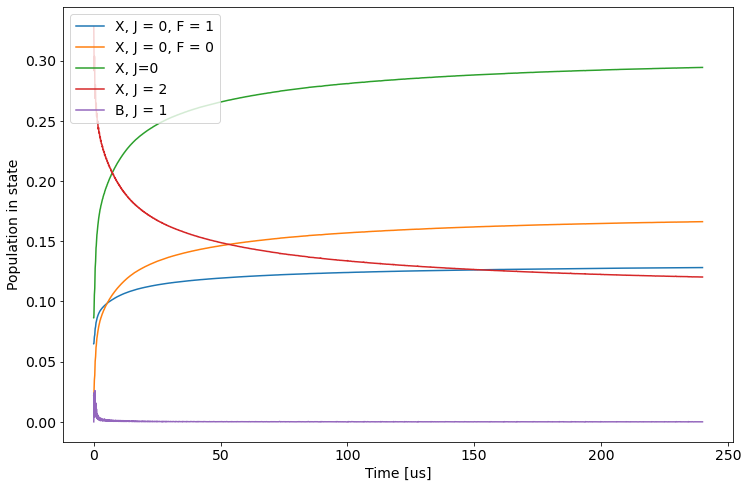

In [1237]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

t_array = sol.t
#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J=0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
# ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

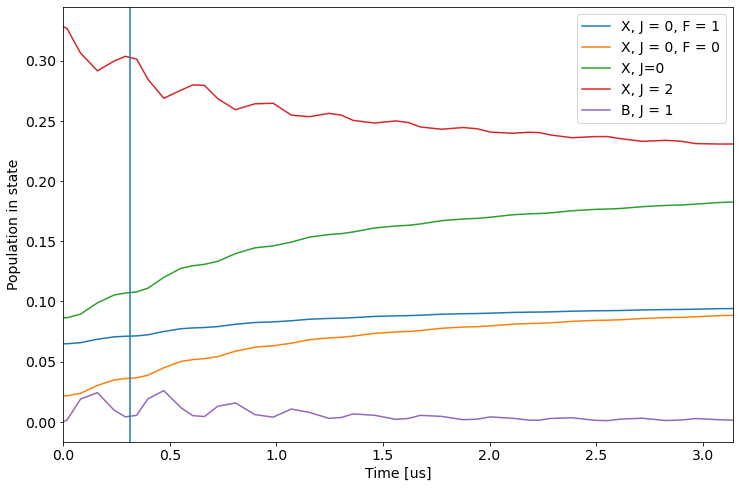

In [1238]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J=0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
# ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
ax.axvline(1e6/wp/2)
# for ti in t_array[:50]*1e6:
#     ax.axvline(ti, color = 'k', zorder = 0)

In [1239]:
print(P0_triplet[-1]/P0_triplet[0])
print(P0_singlet[-1]/P0_singlet[0])
print(P0[-1]/P0[0])

1.9765423664567772
7.694375750643575
3.4060007125034764


## Scan $\Omega$

In [1243]:
from tqdm import tqdm

solutions = {}
for factor in tqdm(np.linspace(0.1, 1, 10)):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Calculate the electric field required to give the desired Rabi rate
    r_t = lambda t: np.array([0,0,0])
    laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
    E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
    # H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    opt = 'greedy'
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))
        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
               -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                       + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()


        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 240e-6

    t_span = (0, T)

    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = 1/wp/2, vectorized = True)
    solutions[factor] = sol

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:56<00:00, 71.65s/it]


In [1252]:
for factor in tqdm([1.1, 1.2, 1.3, 1.4]):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Calculate the electric field required to give the desired Rabi rate
    r_t = lambda t: np.array([0,0,0])
    laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
    E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
    # H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    opt = 'greedy'
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))
        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
               -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                       + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()


        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 240e-6

    t_span = (0, T)

    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = 1/wp/2, vectorized = True)
    solutions[factor] = sol

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [08:18<00:00, 124.70s/it]


In [1255]:
for factor in tqdm([1.6, 1.8, 2.0, 2.2]):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Calculate the electric field required to give the desired Rabi rate
    r_t = lambda t: np.array([0,0,0])
    laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
    E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
    # H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    opt = 'greedy'
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))
        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
               -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                       + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()


        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 240e-6

    t_span = (0, T)

    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = 1/wp/2, vectorized = True)
    solutions[factor] = sol

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [12:09<00:00, 182.29s/it]


In [1259]:
for factor in tqdm([2.4, 2.6, 2.8]):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Calculate the electric field required to give the desired Rabi rate
    r_t = lambda t: np.array([0,0,0])
    laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
    E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
    # H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    opt = 'greedy'
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))
        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
               -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                       + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()


        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 240e-6

    t_span = (0, T)

    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = 1/wp/2, vectorized = True)
    solutions[factor] = sol

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [12:54<00:00, 258.13s/it]


In [1263]:
for factor in tqdm([3.0, 3.2]):
    #Generate optical coupling matrix with set rabi rate
    Omega = factor*Gamma

    #Calculate the electric field required to give the desired Rabi rate
    r_t = lambda t: np.array([0,0,0])
    laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
    E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

    #Define frequency for polarization switching
    omega_p = 1*Gamma
    wp = omega_p/(2*np.pi)
    H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z*square_wave(t, wp, 0) + H_laser_x*square_wave(t, wp, np.pi))
    # H_oc_t = lambda t: (Omega/ME_main)*H_laser_z*np.cos(omega_p*t) + H_laser_x*np.sin(omega_p*t)

    def Hamiltonian(t):
        return _H + H_oc_t(t)
    
    #Define the rhs of the Lindblad equation
    opt = 'greedy'
    def Lindblad_rhs(t, rho_vec):
        dim = int(np.sqrt(len(rho_vec)))
        rho = rho_vec.reshape((dim,dim))
        rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
               np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
               -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                       + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()


        return rhs
    
    #Generate rho vector
    rho_vec = rho_ini.flatten()

    T = 240e-6

    t_span = (0, T)

    sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=True, max_step = 1/wp/2, vectorized = True)
    solutions[factor] = sol

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [10:12<00:00, 306.37s/it]


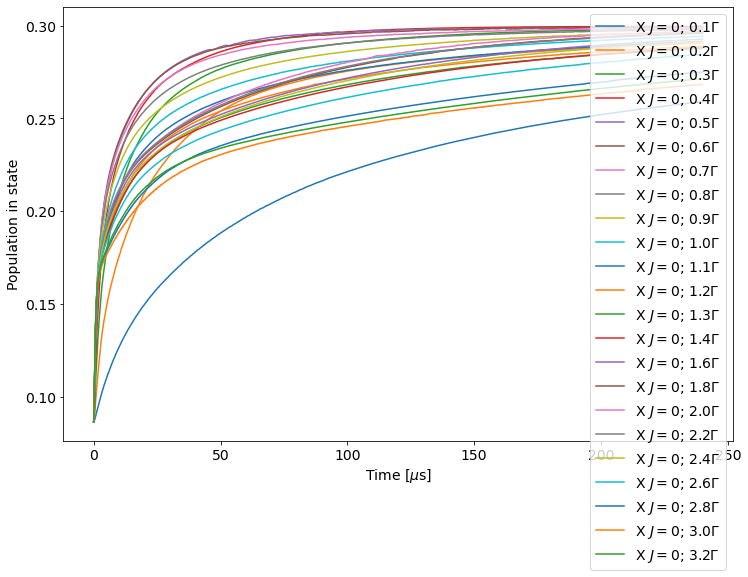

In [1264]:
fig, ax = plt.subplots(figsize = (12,8))

for factor, sol in solutions.items():
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))
    t_array = sol.t
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)
    PB1 = np.sum(pop_results[64:,:], axis = 0)

    ax.plot(t_array*1e6, P0, label = f'X $J=0$; {factor:.1f}$\Gamma$')
#     ax.plot(t_array*1e6, PB1, label = f'B $J=1$ {factor:.1f}$\Gamma$')
    
ax.legend(fontsize = 14)
ax.set_xlabel(r"Time [$\mu$s]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

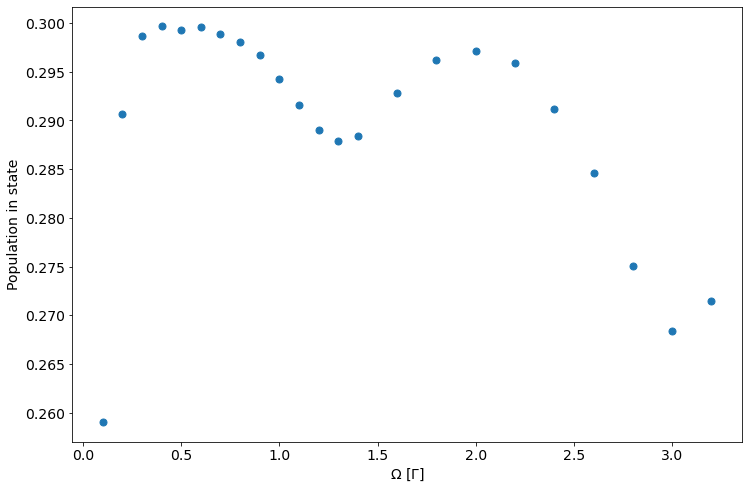

In [1265]:
fig, ax = plt.subplots(figsize = (12,8))

for factor, sol in solutions.items():
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))
    t_array = sol.t
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)
    PB1 = np.sum(pop_results[64:,:], axis = 0)

    ax.plot(factor, P0[-1], '.', ms = 14, color = 'C0')
#     ax.plot(t_array*1e6, PB1, label = f'B $J=1$ {factor:.1f}$\Gamma$')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

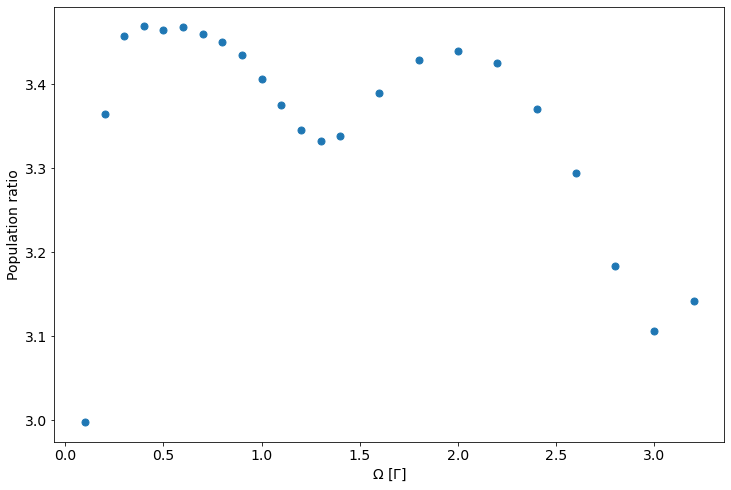

In [1266]:
fig, ax = plt.subplots(figsize = (12,8))

for factor, sol in solutions.items():
    pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))
    t_array = sol.t
    #Plot populations in different J
    P0 = np.sum(pop_results[:4], axis = 0)
    PB1 = np.sum(pop_results[64:,:], axis = 0)

    ax.plot(factor, P0[-1]/P0[0], '.', ms = 14, color = 'C0')
#     ax.plot(t_array*1e6, PB1, label = f'B $J=1$ {factor:.1f}$\Gamma$')
    
ax.set_xlabel(r"$\Omega$ [$\Gamma$]", fontsize = 14)
ax.set_ylabel("Population ratio", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

## Resonant Polarization Modulation

In [956]:
#Calculate effective dipole moment for the optical transitions
Gamma = 1/100e-9 #Natural linewidth in 2*pi*Hz
f = 3e8/271.7e-9 #Frequency in Hz
D_eff = (np.sqrt(3*np.pi*8.85e-12*1.05e-34*3e8**3*Gamma/(2*np.pi*f)**3)
         /(1/3e8 * 1e-21)* 0.393430307 * 5.291772e-9/4.135667e-15)  #Hz/(V/cm)

#Generate optical coupling matrix with set rabi rate
Omega = 2*np.pi*1000e3 #[2pi*Hz]

#Calculate the electric field required to give the desired Rabi rate
r_t = lambda t: np.array([0,0,0])
laser_power = calculate_power_needed(Omega, ME_main, D_TlF = D_eff, fwhm = 1e-3)
E_laser = lambda t: laser_field(r_t(t), power=laser_power, fwhm = 1e-3)

#Define frequency for polarization switching
omega_p = 1*Gamma

wp = omega_p/(2*np.pi)
H_oc_t = lambda t: (Omega/ME_main)*(H_laser_z *(1+np.cos(omega_p*t))/2 + H_laser_x*(1-np.cos(omega_p*t))/2)

H_oc = Omega*H_laser_z/ME_main

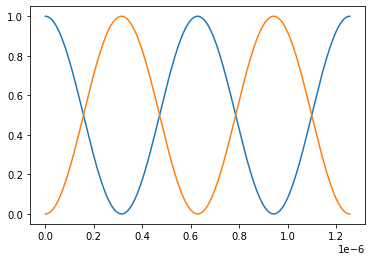

In [957]:
_t = np.linspace(0,2/wp,201)
plt.plot(_t, (1+np.cos(omega_p*_t))/2)
plt.plot(_t, (1-np.cos(omega_p*_t))/2)

In [958]:
H_X_shifted = H_X_red - H_X_red[ground_main_i,ground_main_i]*np.eye(H_X_red.shape[0])

detuning = 0
H_B_shifted = np.diag(np.diag(H_B_red - H_B_diag[excited_main_i,excited_main_i] + detuning))

_H = np.zeros([67,67], dtype = 'complex')
_H[:64, :64] = H_X_shifted
# _H[:64, :64] = 0
_H[64:,64:] = H_B_shifted
# _H[64:,64:] = 0

def Hamiltonian(t):
    return _H + H_oc_t(t)

In [959]:
#Define the rhs of the Lindblad equation
opt = 'greedy'
def Lindblad_rhs(t, rho_vec):
    dim = int(np.sqrt(len(rho_vec)))
    rho = rho_vec.reshape((dim,dim))
    rhs = (-1j* (Hamiltonian(t) @ rho - rho @ Hamiltonian(t)) + 
           np.einsum('ijk,kl,ilm',C_array, rho, C_conj_array,optimize = opt)
           -0.5 * (np.einsum('ijk,ikl,lm', C_conj_array, C_array, rho, optimize = opt)
                   + np.einsum('jk,ikl,ilm', rho, C_conj_array, C_array, optimize = opt))).flatten()
    
    
    return rhs

In [960]:
%%time
from scipy.integrate import solve_ivp

#Generate rho vector
rho_vec = rho_ini.flatten()

T = 240e-6

t_span = (0, T)

sol = solve_ivp(Lindblad_rhs, t_span, rho_vec, dense_output=False, max_step = 1/wp/10, vectorized = True)

Wall time: 2min 40s


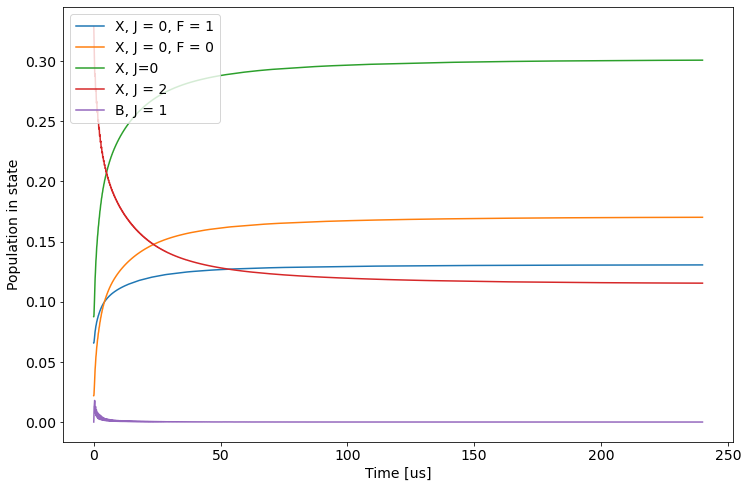

In [961]:
pop_results = np.real(np.einsum('jji->ji',sol.y.reshape((rho_ini.shape[0], rho_ini.shape[1], sol.y.shape[1]))))

t_array = sol.t
#Plot populations in different J
P0_triplet = np.sum(pop_results[1:4,:], axis = 0)
P0_singlet = np.sum(pop_results[0:1,:], axis = 0)
P0 = np.sum(pop_results[:4], axis = 0)
P1 = np.sum(pop_results[4:16,:], axis = 0)
P2 = np.sum(pop_results[16:36,:], axis = 0)
P3 = np.sum(pop_results[36:64,:], axis = 0)
PB1 = np.sum(pop_results[64:,:], axis = 0)

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J=0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
# ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)

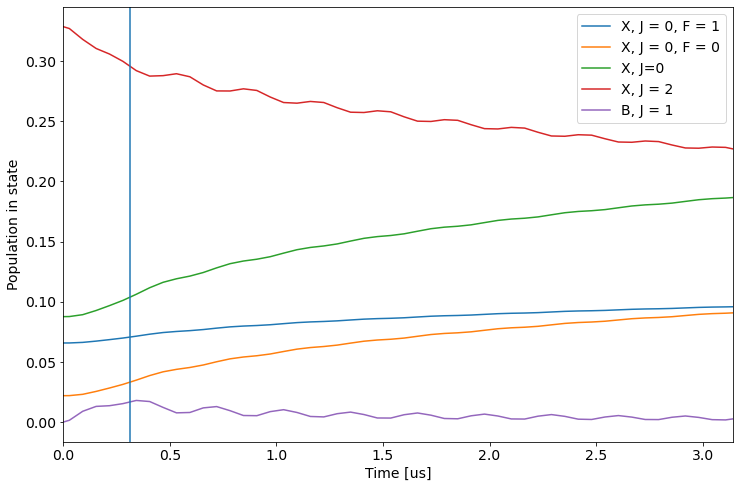

In [962]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(t_array*1e6, P0_triplet, label = 'X, J = 0, F = 1')
ax.plot(t_array*1e6, P0_singlet, label = 'X, J = 0, F = 0')
ax.plot(t_array*1e6, P0, label = 'X, J=0')
# ax.plot(t_array*1e6, P1, label = 'X, J = 1')
ax.plot(t_array*1e6, P2, label = 'X, J = 2')
# ax.plot(t_array*1e6, P3, label = 'X, J = 3')
ax.plot(t_array*1e6, PB1, label = 'B, J = 1')
ax.legend(fontsize = 14)
ax.set_xlabel("Time [us]", fontsize = 14)
ax.set_ylabel("Population in state", fontsize = 14)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(0,5e6/wp)
ax.axvline(1e6/wp/2)
# for ti in t_array[:50]*1e6:
#     ax.axvline(ti, color = 'k', zorder = 0)

In [963]:
print(P0_triplet[-1]/P0_triplet[0])
print(P0_singlet[-1]/P0_singlet[0])
print(P0[-1]/P0[0])

1.987684121946357
7.770754520348876
3.433451721546987
